In [3]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

# Historical ECMWF Review in Ethiopia

In [4]:
import xarray as xr
import pandas as pd
import tqdm
import os
from dotenv import load_dotenv
from azure.storage.blob import ContainerClient
import rioxarray as rxr
import geopandas as gpd
import zipfile
import matplotlib.pyplot as plt
import re
import plotly.express as px
from dateutil.relativedelta import relativedelta

load_dotenv()

PROD_BLOB_SAS = os.getenv("DSCI_AZ_SAS_PROD")
PROD_BLOB_NAME = "imb0chd0prod"
PROD_BLOB_URL = f"https://{PROD_BLOB_NAME}.blob.core.windows.net/"
PROD_BLOB_GLB_URL = PROD_BLOB_URL + "raster" + "?" + PROD_BLOB_SAS
prod_rst_container_client = ContainerClient.from_container_url(PROD_BLOB_GLB_URL)

DEV_BLOB_SAS = os.getenv("DSCI_AZ_SAS_DEV")
DEV_BLOB_NAME = "imb0chd0dev"
DEV_BLOB_URL = f"https://{DEV_BLOB_NAME}.blob.core.windows.net/"
DEV_BLOB_PRJ_URL = DEV_BLOB_URL + "projects" + "?" + DEV_BLOB_SAS
DEV_BLOB_GLB_URL = DEV_BLOB_URL + "raster" + "?" + DEV_BLOB_SAS
dev_prj_container_client = ContainerClient.from_container_url(DEV_BLOB_PRJ_URL)
dev_rst_container_client = ContainerClient.from_container_url(DEV_BLOB_GLB_URL)

Load in 2024 ETH CODS:

In [5]:
fname = "Admin_2024.gdb.zip"
blob_name = f"ds-aa-eth-drought/raw/cod_ab/{fname}"
adm_level = 2

blob_client = dev_prj_container_client.get_blob_client(blob_name)
download_file_path = os.path.join(os.getcwd(), "data", fname)
with open(download_file_path, "wb") as download_file:
    download_file.write(blob_client.download_blob().readall())

extracted_dir = os.path.join(os.getcwd(), "data")
with zipfile.ZipFile(download_file_path, "r") as zip_ref:
    zip_ref.extractall(extracted_dir)

In [6]:
gdf3 = gpd.read_file(
    "data/Admin_2024.gdb", layer=f"eth_admbnda_adm{adm_level}_csa_bofedb_2024"
)
gdf0 = gpd.read_file("data/Admin_2024.gdb", layer=f"eth_admbnda_adm0_csa_bofedb_2024")

Filtering for geographic coverage focused on selected zones with September start of OND season (see [this slide](https://docs.google.com/presentation/d/1vZayUcBbA2NJfJWsO4vxskxP-xnPsRoJG10YNzwkClM/edit#slide=id.g2e7474f9ddb_0_1)). The selected Zones are hard-coded based on [this previous analysis](https://github.com/OCHA-DAP/ds-aa-eth-drought/blob/5d7a19d36f1dfb2bbd6312ddb9f8622396a63fae/analysis/01_1_reviewing_july_forecast_for_ond.R#L36-L41).

In [7]:
ond_zones = [
    "ET0508",
    "ET0806",
    "ET0808",
    "ET0411",
    "ET0412",
    "ET0810",
    "ET0511",
    "ET0807",
    "ET0507",
    "ET0421",
    "ET0410",
    "ET0504",
    "ET0502",
    "ET0802",
    "ET0414",
    "ET0503",
    "ET0809",
    "ET0505",
    "ET0509",
    "ET0510",
    "ET0506",
    "ET0812",
    "ET0415",
    "ET0422",
]

gdf3_sel = gdf3[gdf3.admin2Pcode.isin(ond_zones)]

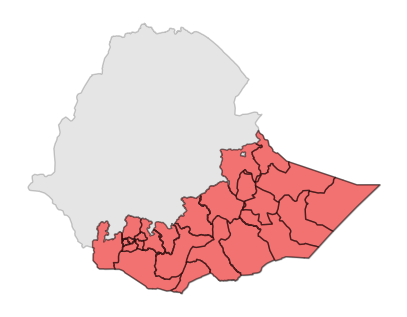

In [8]:
ax = gdf0.plot(color="gray", edgecolor="black", alpha=0.2, figsize=(5, 5))
gdf3_sel.plot(ax=ax, color="red", edgecolor="black", alpha=0.5)

ax.axis("off")
plt.show()

# Also create a single dissolved gdf of the area of interest
gdf_sel = gdf3_sel.dissolve()

## Process and clip the COGs

Now load in and process the historical precipitation data. Let's start by taking in the SEAS5 seasonal forecasts. We need to also get the updated 2024 forecast data from Azure. We'll also clip to the AOI in Ethiopia.

In [9]:
def process_cogs(cogs_list, gdf_clip):

    minx, miny, maxx, maxy = gdf_clip.total_bounds
    das_tp = []

    # Total days in the month, given leadtime month
    days_in_month = {2: 31, 3: 30, 4: 31}

    for blob_name in tqdm.tqdm(cogs_list):

        cog_url = (
            f"https://{PROD_BLOB_NAME}.blob.core.windows.net/raster/"
            f"{blob_name}?{PROD_BLOB_SAS}"
        )

        date_in = pd.to_datetime(blob_name.split(".")[0][-14:-4])
        lt = int(blob_name.split("-")[2][-5:-4])
        year = int(blob_name.split("-")[0][-4:])
        days = days_in_month[lt]

        da_in = rxr.open_rasterio(cog_url, masked=True, chunks={"x": 225, "y": 900})
        da_in = da_in.sel(x=slice(minx, maxx), y=slice(maxy, miny))

        da_in = da_in.squeeze(drop=True)
        da_in["year"] = year
        da_in["forecast_date"] = date_in + relativedelta(months=lt)
        da_in = da_in.persist()

        # Get total precipitation
        da_tp = da_in * 3600 * 24 * days * 1000
        da_tp = da_tp.assign_attrs(
            units="mm", long_name="Total accumulated precipitation"
        )

        das_tp.append(da_tp)

    ds_tp = xr.concat(das_tp, dim="forecast_date").rio.set_spatial_dims(
        x_dim="x", y_dim="y"
    )
    ds_tp_clip = ds_tp.rio.clip(gdf_clip.geometry)

    return ds_tp_clip

There seems to be grid misalignment issues between the AWS and MARS data, so we're aggregating these separately.

In [10]:
# OND dates - for forecasts published in Aug
# File names have the publish date
dates = [f"08-01_lt2", f"08-01_lt3", f"08-01_lt4"]
dates = "|".join(dates)

blob_names_mars = [
    x.name
    for x in prod_rst_container_client.list_blobs(
        name_starts_with="seas5/mars/processed"
    )
    if re.search(dates, x.name)
]

blob_names_aws = [
    x.name
    for x in prod_rst_container_client.list_blobs(
        name_starts_with="seas5/aws/processed"
    )
    if re.search(dates, x.name)
]

In [11]:
ds_aws = process_cogs(blob_names_aws, gdf_sel)
ds_mars = process_cogs(blob_names_mars, gdf_sel)

100%|██████████| 129/129 [00:47<00:00,  2.70it/s]


Let's plot both to sanity check

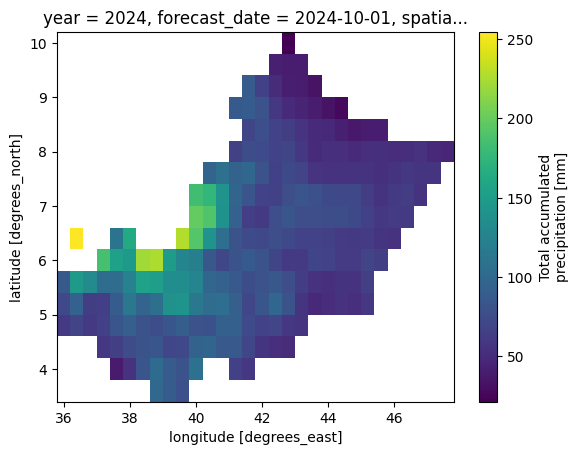

In [12]:
ds_aws.sel({"forecast_date": "2024-10-01"}).plot()

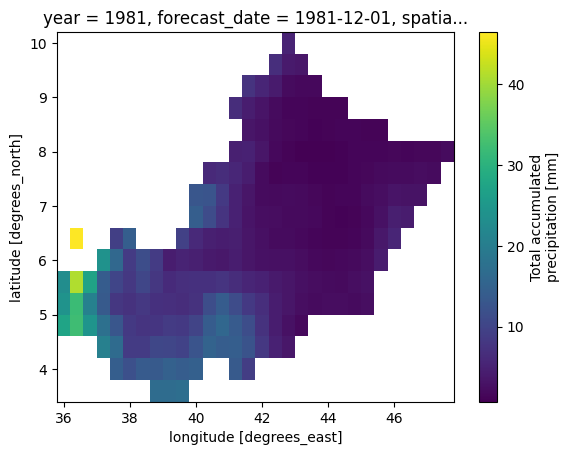

In [13]:
ds_mars.sel({"forecast_date": "1981-12-01"}).plot()

## Take the mean by year

In [163]:
# For 2024 data from AWS -- just a single value for OND
ds_2024 = ds_aws.mean(dim=["x", "y", "forecast_date"])
precip_2024 = int(ds_2024.values)

In [165]:
ds_mean = ds_mars.groupby("year").mean()
ds_total_mean = ds_mean.mean(dim=["x", "y"])
df_seas5 = (
    ds_total_mean.to_dataframe(name="mean_ond_precip")
    .reset_index()
    .drop(columns="spatial_ref")
)

Add the 2024 observation to the overall dataframe

In [166]:
df_seas5 = pd.concat(
    [df_seas5, pd.DataFrame([{"year": 2024, "mean_ond_precip": precip_2024}])],
    ignore_index=True,
)

In [168]:
mean = df_seas5.mean_ond_precip.mean()

## Make a plot of the overall distribution

In [187]:
def plot_distribution(df, drought_years=[2010, 2020, 2022]):

    fig = px.histogram(df, x="mean_ond_precip", nbins=20, template="simple_white")
    fig.update_layout(
        yaxis=dict(title="Count of Years"),
        xaxis=dict(title="Mean OND Precipitation (mm)"),
        title=dict(
            text="Distribution of ECMWF Forecasted Mean OND Precipitation in Southern Ethiopia from 1981 to 2024",
        ),
        font=dict(family="Arial"),
    )

    fig.update_traces(marker_color="#35B678")

    for year in drought_years:
        precip = df.loc[df["year"] == year, "mean_ond_precip"].values[0]
        # TODO: For some reason vline isn't working, so slightly hacking with vrect
        fig.add_vrect(
            x0=(precip - 0.05), x1=(precip + 0.05), opacity=1, fillcolor="red"
        )
        fig.add_annotation(
            text=f"<b>{year}</b>",
            x=(precip + 0.35),
            y=15,
            showarrow=False,
            textangle=90,
            font=dict(color="red"),
        )

    return fig

In [188]:
fig = plot_distribution(df_seas5)

In [190]:
fig.add_vrect(
    x0=(precip_2024 - 0.05), x1=(precip_2024 + 0.05), opacity=1, fillcolor="black"
)
fig.add_annotation(
    text=f"<b>2024</b>",
    x=(precip_2024 - 0.35),
    y=15,
    showarrow=False,
    textangle=90,
    font=dict(color="black"),
)

Let's get the mean/median of the precipitation values as well... The total accumulated precipitation for OND 2024 is slightly below both the mean and median historical precipitation for OND. 

In [191]:
df_seas5.mean_ond_precip.mean()

42.58700119365346

In [192]:
df_seas5.mean_ond_precip.median()

40.066917419433594

In [193]:
precip_2024

39

## Now let's take a look at the ERA5 reanalysis and see how it compares

In [36]:
dates = [f"-10-01", f"-11-01", f"-12-01"]
dates = "|".join(dates)

blob_names = [
    x.name
    for x in dev_rst_container_client.list_blobs(
        name_starts_with="era5/monthly/processed"
    )
    if re.search(dates, x.name)
]

In [240]:
minx, miny, maxx, maxy = gdf_sel.total_bounds

das_tp = []

# Total days in the month, given month
days_in_month = {10: 31, 11: 30, 12: 31}

for blob_name in tqdm.tqdm(blob_names):

    cog_url = (
        f"https://{DEV_BLOB_NAME}.blob.core.windows.net/raster/"
        f"{blob_name}?{DEV_BLOB_SAS}"
    )

    date_in = blob_name[-14:-4]
    year = int(date_in[:4])
    month = int(date_in[5:7])
    days = days_in_month[month]
    date_in = pd.to_datetime(date_in)

    da_in = rxr.open_rasterio(cog_url, masked=True, chunks={"x": 225, "y": 900})
    da_in = da_in.sel(x=slice(minx, maxx), y=slice(maxy, miny))

    da_in = da_in.squeeze(drop=True)
    da_in["date"] = date_in
    da_in["year"] = year
    da_in = da_in.persist()

    # Convert from m (daily) to mm (monthly)
    da_tp = da_in * 1000 * 30
    da_tp = da_tp.assign_attrs(units="mm")

    das_tp.append(da_tp)

ds_tp_era5 = xr.concat(das_tp, dim="date").rio.set_spatial_dims(x_dim="x", y_dim="y")
ds_tp_clip_era5 = ds_tp_era5.rio.clip(gdf_sel.geometry)

100%|██████████| 129/129 [01:07<00:00,  1.91it/s]


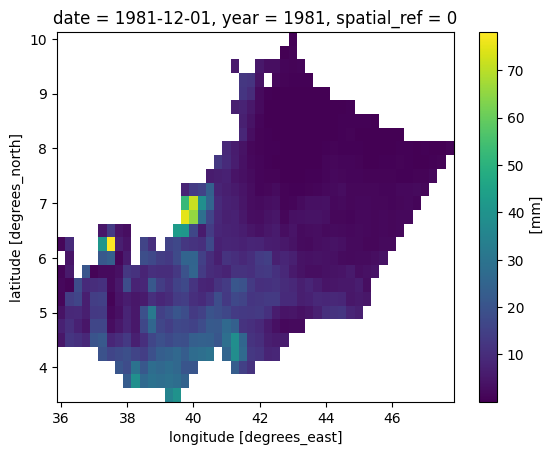

In [197]:
ds_tp_clip_era5.sel({"date": "1981-12-01"}).plot()

In [229]:
ds_mean = ds_tp_clip_era5.groupby("year").mean()
ds_total_mean = ds_mean.mean(dim=["x", "y"])
df_era5 = (
    ds_total_mean.to_dataframe(name="mean_ond_precip")
    .reset_index()
    .drop(columns="spatial_ref")
)

In [212]:
fig = px.histogram(df_era5, x="mean_ond_precip", nbins=20, template="simple_white")
fig.update_layout(
    yaxis=dict(title="Count of Years"),
    xaxis=dict(title="Mean OND Precipitation (mm)"),
    title=dict(
        text="Distribution of ECMWF Reanalysis Mean OND Precipitation in Southern Ethiopia from 1981 to 2023",
    ),
    font=dict(family="Arial"),
)

fig.update_traces(marker_color="#35B678")

for year in [2010, 2020, 2022]:
    precip = df_era5.loc[df_era5["year"] == year, "mean_ond_precip"].values[0]
    # TODO: For some reason vline isn't working, so slightly hacking with vrect
    fig.add_vrect(x0=(precip - 0.05), x1=(precip + 0.05), opacity=1, fillcolor="red")
    fig.add_annotation(
        text=f"<b>{year}</b>",
        x=(precip + 0.9),
        y=12,
        showarrow=False,
        textangle=90,
        font=dict(color="red"),
    )

fig.add_vrect(
    x0=(precip_2024 - 0.05), x1=(precip_2024 + 0.05), opacity=1, fillcolor="black"
)
fig.add_annotation(
    text=f"<b>2024</b>",
    x=(precip_2024 + 0.9),
    y=12,
    showarrow=False,
    textangle=90,
    font=dict(color="black"),
)

# Calculating zonal deviation from the mean

To sanity check, we can take a look at how the SEAS5 and ERA5 resolution compares against the size of these zones.

Text(0.5, 1.0, 'Forecasted 2024 OND Precipitation (mm) \nSEAS5 Seasonal Forecast')

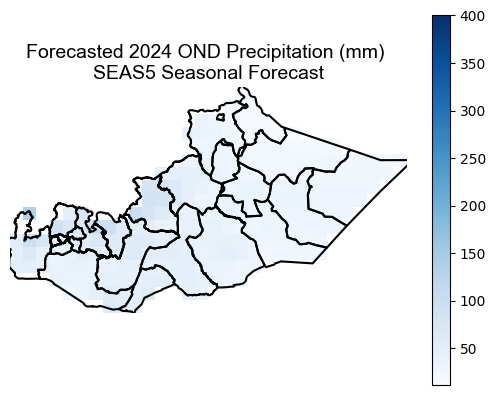

In [398]:
ds_2024_mean = ds_aws.mean(dim="forecast_date")

fig, ax = plt.subplots()
ds_2024_mean.plot(ax=ax, cmap="Blues", vmax=400)
gdf3_sel.boundary.plot(ax=ax, edgecolor="black")
ax.set_axis_off()
ax.set_title(
    "Forecasted 2024 OND Precipitation (mm) \nSEAS5 Seasonal Forecast",
    fontdict={"fontsize": 14, "fontname": "Arial"},
)

Text(0.5, 1.0, 'Average Monthly OND Precipitation (mm) \n1981 - 2023 ERA5 Reanalysis')

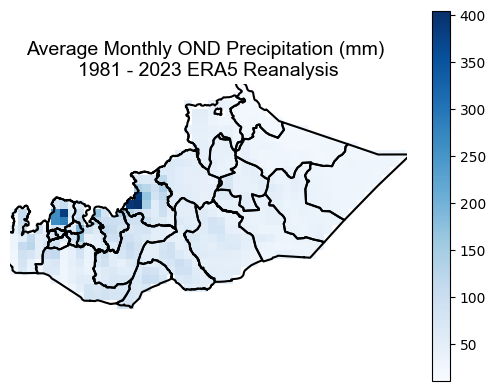

In [399]:
ds_era5_mean = ds_tp_clip_era5.groupby("year").mean().mean(dim="year")

fig, ax = plt.subplots()
ds_era5_mean.plot(ax=ax, cmap="Blues")
gdf3_sel.boundary.plot(ax=ax, edgecolor="black")
ax.set_axis_off()
ax.set_title(
    "Average Monthly OND Precipitation (mm) \n1981 - 2023 ERA5 Reanalysis",
    fontdict={"fontsize": 14, "fontname": "Arial"},
)

In [403]:
adm2s = []
mean_ond_precip = []
forecast_2024_precip = []
geoms = []

for admin2 in gdf3_sel.admin2Pcode:
    gdf_zone = gdf3_sel[gdf3_sel.admin2Pcode == admin2]
    
    # Using all_touched=True since some zones are so small that they don't contain any pixel centroids
    ds_era5_clip = ds_era5_mean.rio.clip(gdf_zone.geometry, all_touched=True)
    ds_2024_clip = ds_2024_mean.rio.clip(gdf_zone.geometry, all_touched=True)

    precip = float(ds_era5_clip.mean().values)
    precip_2024 = float(ds_2024_clip.mean().values)

    adm2s.append(admin2)
    mean_ond_precip.append(precip)
    forecast_2024_precip.append(precip_2024)

In [404]:
data = {
    "admin2Pcode": adm2s,
    "MEAN_OND_PRECIP": mean_ond_precip,
    "2024_FORECAST_PRECIP": forecast_2024_precip,
}
df_mean = pd.DataFrame(data)
gdf_mean = gdf3_sel.merge(df_mean, on="admin2Pcode", how="inner")
gdf_mean["PRECIP_DIFF"] = gdf_mean["2024_FORECAST_PRECIP"] - gdf_mean["MEAN_OND_PRECIP"]

Text(0.5, 0.88, 'Total mm deviation from mean reanalysis')

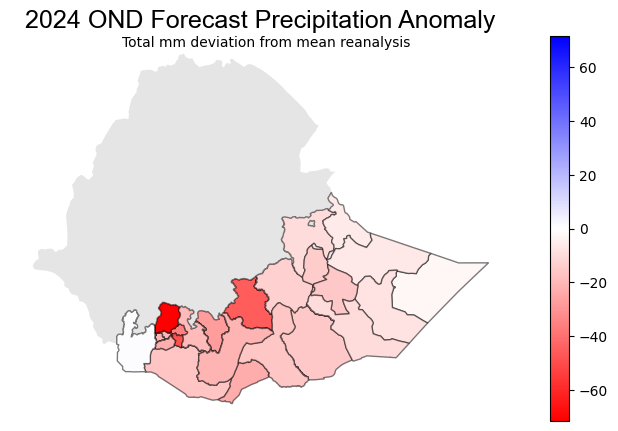

In [405]:
vmin = gdf_mean["PRECIP_DIFF"].min()
vmax = gdf_mean["PRECIP_DIFF"].max()
abs_max = max(abs(vmin), abs(vmax))

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
gdf0.plot(ax=ax, color="gray", alpha=0.2)
gdf_mean.plot(
    column="PRECIP_DIFF",
    cmap="bwr_r",
    ax=ax,
    legend=True,
    vmin=-abs_max,
    vmax=abs_max,
    edgecolor=(0, 0, 0, 0.5),
)
ax.set_axis_off()
ax.set_title(
    "2024 OND Forecast Precipitation Anomaly",
    fontdict={"fontsize": 18, "fontname": "Arial"},
)
fig.suptitle("Total mm deviation from mean reanalysis", fontsize=10, y=0.88)

# Calculating return period

In [230]:
df_era5_w_2024 = pd.concat(
    [df_era5, pd.DataFrame([{"year": 2024, "mean_ond_precip": precip_2024}])],
    ignore_index=True,
)


def rp_calc(df):
    df_sorted = df.sort_values(by="mean_ond_precip", ascending=True).reset_index(
        drop=True
    )

    df_sorted["rank"] = df_sorted.index + 1
    n = len(df_sorted)  # Number of years in the dataset
    df_sorted["return_period"] = (n + 1) / df_sorted["rank"]
    return df_sorted

In [231]:
df_era5_rp = rp_calc(df_era5_w_2024)
df_seas5_rp = rp_calc(df_seas5)

In [232]:
print(df_era5_rp[df_era5_rp["year"] == 2024])
print(df_seas5_rp[df_seas5_rp["year"] == 2024])

    year  mean_ond_precip  rank  return_period
10  2024             39.0    11       4.090909
    year  mean_ond_precip  rank  return_period
16  2024             39.0    17       2.647059
